# Problem Statement

- Amazon is an online shopping website that now caters to millions of people everywhere. Over 4,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
- The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
- Goal is to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [1]:
import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
import re,string
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')



In [2]:
#load train dataset and check first 5 records

train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
train_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


#### Check info of the data

In [3]:
#shape 
train_df.shape,test_df.shape

((4000, 8), (1000, 8))

#### training dataset contains 4k records and 8 features and testing dataset have 1k records.

In [4]:
# info
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


#### train dataset contains  8 features, all are ojects type.

In [5]:
#describe
train_df.describe().transpose()

,count,unique,top,freq
name,4000,23,Amazon Echo Show Alexa-enabled Bluetooth Speak...,676
brand,4000,1,Amazon,4000
categories,4000,23,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",628
primaryCategories,4000,4,Electronics,2600
reviews.date,4000,638,2017-01-23T00:00:00.000Z,99
reviews.text,4000,3598,I bought this kindle for my 11yr old granddaug...,4
reviews.title,3990,2606,Great tablet,100
sentiment,4000,3,Positive,3749


#### Observations from the above train data 
- Dataset contains total 4 primary categories.
- Electronics category is the most used one with 2600 records
- Total subcategories are 23, brand is only one i.e. Amazon. 
- Total 3 types of sentiments are there Positive,Neagtive and Neutral, most of the sentiments looks Positive i.e. 3749 positive   records are there.

In [6]:
train_df.groupby('primaryCategories').nunique()

,name,brand,categories,reviews.date,reviews.text,reviews.title,sentiment
primaryCategories,,,,,,,
Electronics,18,1,17,458,2310,1706,3
"Electronics,Hardware",2,1,3,203,1095,827,3
"Electronics,Media",1,1,1,16,17,17,1
"Office Supplies,Electronics",2,1,2,140,204,181,3


In [7]:
train_df['reviews.date'] = pd.to_datetime(train_df['reviews.date'])
train_df.groupby('reviews.date')['reviews.date'].count().sort_values(ascending=False)

reviews.date
2017-01-23 00:00:00+00:00    99
2017-01-18 00:00:00+00:00    88
2017-01-06 00:00:00+00:00    87
2017-12-01 00:00:00+00:00    73
2017-01-16 00:00:00+00:00    69
                             ..
2016-10-25 00:00:00+00:00     1
2017-11-19 07:47:58+00:00     1
2016-10-18 00:00:00+00:00     1
2016-10-10 00:00:00+00:00     1
2018-09-15 15:58:24+00:00     1
Name: reviews.date, Length: 638, dtype: int64

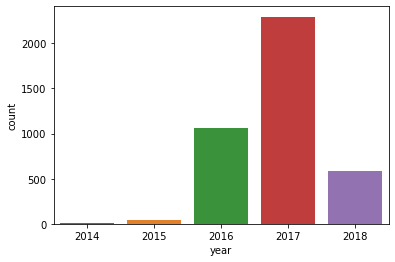

In [8]:
train_df['year'] = train_df['reviews.date'].dt.year
train_df['month'] = train_df['reviews.date'].dt.month
train_df['weekday'] = train_df['reviews.date'].dt.dayofweek

sns.countplot(x ='year', data = train_df)
plt.show()

#### Most of the reviews collected in the year 2017

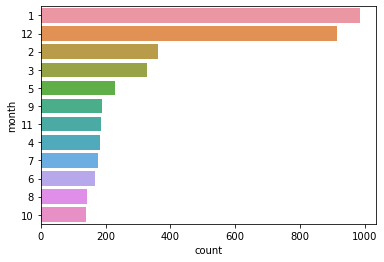

In [9]:
sns.countplot(y ='month', data = train_df,order = train_df['month'].value_counts().index)
plt.show()

#### Most of the reviews are in the month of Jan and Dec, so people might purchased more in these 2 months.

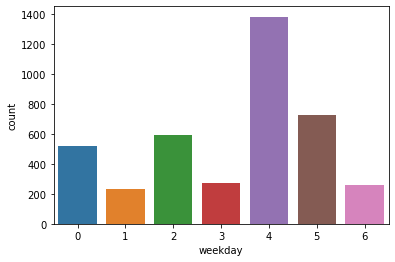

In [10]:
sns.countplot(x ='weekday', data = train_df)
plt.show()

In [11]:
# Most of the people purchased mostly on friday

In [12]:
#### Check for minimum and maximum length for review text

long_review_length = train_df["reviews.text"].map(len).max()
short_review_length = train_df["reviews.text"].map(len).min()
avg_review_length = round(train_df["reviews.text"].map(len).mean())
short_review_length,avg_review_length,long_review_length

(45, 159, 8351)

#### Longest review is 8351 char., shortest review length is 45 char. and average is 159 char. long 

In [13]:
# Check the words used in review

train_df['totalwords'] = [len(x.split()) for x in train_df["reviews.text"].tolist()]
train_df['maxwordlen'] = [len(max(x.split(), key=len)) for x in train_df["reviews.text"].tolist()]

maximum_words = train_df.totalwords.max()
minimum_words = train_df.totalwords.min()
average_words = round(train_df.totalwords.mean())

maximum_words,minimum_words,average_words

(1539, 1, 31)

#### 1539 Maximum words used in review, Minimum words used is 1 and average words used are 31.

In [14]:
#Check fewer words reviews.

train_df[train_df['totalwords']<=5]

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,year,month,weekday,totalwords,maxwordlen
177,Amazon 9W PowerFast Official OEM USB Charger a...,Amazon,"Computers & Accessories,Tablet & E-Reader Acce...",Electronics,2016-07-16 00:00:00+00:00,Works great !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,Good,Positive,2016,7,5,3,39
1296,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-01 00:00:00+00:00,As advertised....................................,As advertised,Positive,2017,12,4,2,48
1679,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-05 00:00:00+00:00,"So much fun, love it.............................",Alexa,Positive,2018,1,4,5,61
2477,"Amazon - Kindle Voyage - 6"" - 4GB - Black",Amazon,"eBook Readers,Electronics Features,Walmart for...",Electronics,2015-04-17 00:00:00+00:00,Realllllllllllllllllllllllllllllllllllllllllll...,it's awesome,Positive,2015,4,4,1,51
2799,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2017-01-07 00:00:00+00:00,Great!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,Great,Positive,2017,1,5,1,50
2973,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-02-11 00:00:00+00:00,Excellent product.Relable.Maximum speed.Fast d...,Good,Positive,2017,2,5,4,23
3467,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-02-05 00:00:00+00:00,asesome!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,awesome,Positive,2017,2,6,1,112
3493,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2017-01-06 00:00:00+00:00,Son loves it.....................................,Great for kids,Neutral,2017,1,4,3,42


#### Check for missing values

In [15]:
train_df.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
year                  0
month                 0
weekday               0
totalwords            0
maxwordlen            0
dtype: int64

#### reviews.title contains 10 missing values, but we can ignore it for now, as our main focus is on review text.

#### Check for duplicate values

In [16]:
train_df.duplicated().sum()

58

#### total 58 records are duplicated. 

#### Doing the product wise review analysis

In [17]:
train_df.groupby(['name'])['brand'].count().sort_values(ascending=False).head(5)

name
Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                             676
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta    628
Amazon - Echo Plus w/ Built-In Hub - Silver                                                 483
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                      446
Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue                     372
Name: brand, dtype: int64

- highest review recevied for  Aleax enabled 7" bluetooth speaker 

#### Review cateogrywise sentiments  

In [18]:
df_cat_sentiment = train_df.groupby(['primaryCategories','sentiment'])['brand'].count()
df_cat_sentiment

primaryCategories            sentiment
Electronics                  Negative       72
                             Neutral       114
                             Positive     2414
Electronics,Hardware         Negative       19
                             Neutral        32
                             Positive     1108
Electronics,Media            Positive       17
Office Supplies,Electronics  Negative        3
                             Neutral        11
                             Positive      210
Name: brand, dtype: int64

<AxesSubplot:ylabel='primaryCategories'>

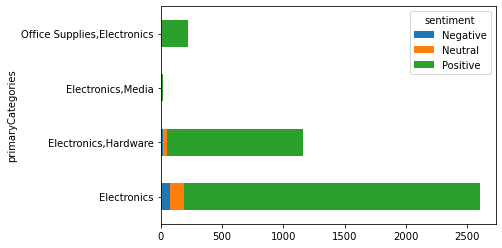

In [19]:
 df_cat_sentiment.unstack().plot(kind='barh',stacked=True)

- Majority of reviews are in Electronics category and most of them are Positive reviews
- Electronics,Media contains very few reviews and all are positive

In [20]:
#### We can check most frequent words using Wordcount for each sentiment

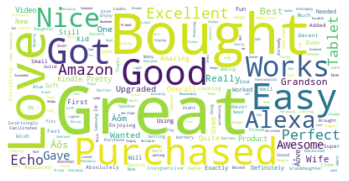

In [21]:
#Most frequent word used in Positive sentiment

Positive_data = train_df.loc[train_df['sentiment']=='Positive', 'reviews.text']
words = " ".join(Data.split()[0] for Data in Positive_data)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

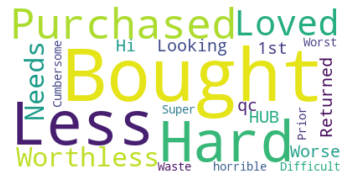

In [22]:
#Most frequent word used in Negative sentiment

Negative_data = train_df.loc[train_df['sentiment']=='Negative', 'reviews.text']
words = " ".join(Data.split()[0] for Data in Negative_data)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

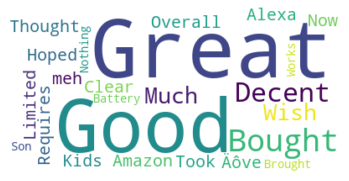

In [23]:
#Most frequent word used in Neutral sentiment

Negative_data = train_df.loc[train_df['sentiment']=='Neutral', 'reviews.text']
words = " ".join(Data.split()[0] for Data in Negative_data)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Distribution of each sentiment

train_df.sentiment.value_counts()

Positive    3749
Neutral      157
Negative      94
Name: sentiment, dtype: int64

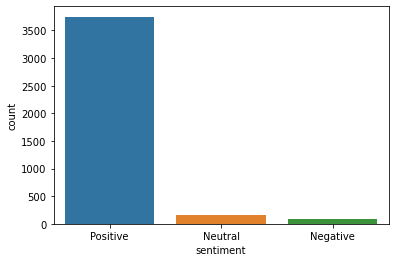

In [25]:

sns.countplot(train_df['sentiment'])
plt.show()

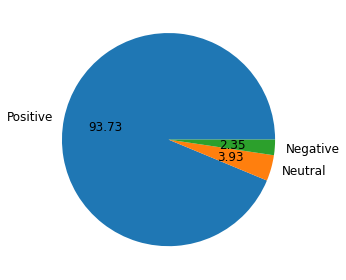

In [26]:
# Check the percentage of each sentiment type

train_df.sentiment.value_counts().plot(kind='pie',autopct='%.2f',textprops={'fontsize': 12},label='')
plt.tight_layout()
plt.show()

#### More than 93 percent data is for positive sentiment. 3.93 percent is Neutral and 2.35 percent Negative sentiments. The data is higly imbalanced. Will review later on imbalance data 

## Data Preprocessing

In [27]:
#### We can remove duplicate entries as we need to use unique enteries for better analysis
duplicated_data = train_df.duplicated(keep='first')
df_new = train_df[~duplicated_data] 
df_new.shape

(3942, 13)

In [28]:
#### keep only those review which contains at least 5 words
df_new = df_new.loc[(train_df['totalwords']>5)]
df_new.shape

(3934, 13)

In [29]:
def word_baseword(word):
    import nltk
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    from nltk.corpus import wordnet as wn

    noun_list = ['NN', 'NNS', 'NNP', 'NNPS']
    verb_list = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    adverb_list = ['RB', 'RBR', 'RBS']
    adjective_list = ['JJ', 'JJR', 'JJS']
        
    
    tags = nltk.pos_tag(word_tokenize(word))
    for tag in tags:

        if tag[1] in adjective_list:
            word = WordNetLemmatizer().lemmatize(tag[0],wn.ADJ) 
        elif tag[1] in noun_list:
            word = WordNetLemmatizer().lemmatize(tag[0],wn.NOUN) 
        elif tag[1] in adverb_list:
            word = WordNetLemmatizer().lemmatize(tag[0],wn.ADV)
        elif tag[1] in verb_list:
             word = WordNetLemmatizer().lemmatize(tag[0], wn.VERB)
   
    return word

In [30]:
def preprocess_text(text,tokenizer=None):
    
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()
    text = text.replace(".",", ").replace(". ", ", ")
    text = re.sub(r'[()]', " ", text)
    text = re.sub(r"\d+"," ",text)
    text = text.translate(str.maketrans('','',string.punctuation))

    new_stopwords = ["amazon","pros","cons","ive"]
    exclude_words = ["not"]
    stop_words = nltk.corpus.stopwords.words('english')
    
    for word in exclude_words:
        stop_words.remove(word)
    
    stop_words.extend(new_stopwords)

    tokens = word_tokenize(text)  # Get tokens from text
    tokens = [word_baseword(t) for t in tokens if not t in stop_words]  # Remove stopwords
    
    #tokens = [word_baseword(t) for t in tokens]  # Remove stopwords
    tokens = [t for t in tokens if len(t) > 2]  # Remove short tokens

    
    if tokenizer is not None:
        return tokens
    else:
        clean_tokens = []
        for tok in tokens:
            tok = tok.strip() # remove space
            clean_tokens.append(tok)
        return " ".join(clean_tokens)


In [31]:
X = df_new['reviews.text']
y = df_new['sentiment']

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.20,random_state=42)
X_train.shape,X_val.shape

((3147,), (787,))

In [33]:
X_train = X_train.apply(lambda x: preprocess_text(x,))
X_train_clean = X_train
y_train_clean = y_train

X_test = test_df['reviews.text']
y_test = test_df['sentiment']

X_train.head()

1963    first tablet far pleased fire tablet not gamer...
2360    quite satisfied purchase however pay dollar sm...
3084    ereader great start reading kindle read paperb...
1567              good tablet kid lot appts download game
1922    touch load content bad doesnt respond quickly ...
Name: reviews.text, dtype: object

In [34]:
X_test[:1]

0    Amazon kindle fire has a lot of free app and c...
Name: reviews.text, dtype: object

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 

In [36]:
MNB_model = Pipeline([("vect", CountVectorizer(stop_words= "english")), 
                            ("tfidf", TfidfTransformer()), 
                            ("clf_multinomialnb", MultinomialNB())])


In [37]:
MNB_model.fit(X_train,y_train)
predictedMultiNB = MNB_model.predict(X_val)

In [38]:
confusion_matrix(predictedMultiNB,y_val)

array([[  0,   0,   0],
       [  0,   0,   0],
       [ 19,  23, 745]], dtype=int64)

In [39]:
print(classification_report(y_val, predictedMultiNB))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        19
     Neutral       0.00      0.00      0.00        23
    Positive       0.95      1.00      0.97       745

    accuracy                           0.95       787
   macro avg       0.32      0.33      0.32       787
weighted avg       0.90      0.95      0.92       787



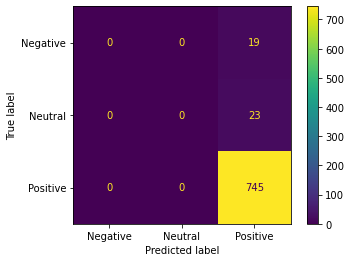

In [40]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(MNB_model,X_val,y_val)
plt.show()

#### validate if every review is 'Positive'

In [41]:
newtext = ['bad product']
predict_text = MNB_model.predict(newtext)
predict_text[0]

'Positive'

#### Dataset is imbalanced because of that every predicted review is 'Positive'. 
#### We need to balanced data to get the better predicted result

#### review data is text data, so first we need to convert text data to vector data 

In [42]:
#Resampling minority class using SMOTE

In [43]:
# Now again we can test with MultinomialNB

In [44]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import AdaBoostClassifier

MNB = make_pipeline_imb(TfidfVectorizer(), SMOTE(), MultinomialNB())
DT = make_pipeline_imb(TfidfVectorizer(), SMOTE(), DecisionTreeClassifier())
RF = make_pipeline_imb(TfidfVectorizer(), SMOTE(), RandomForestClassifier())
SVM = make_pipeline_imb(TfidfVectorizer(), SMOTE(), LinearSVC())
ADA = make_pipeline_imb(TfidfVectorizer(), SMOTE(), AdaBoostClassifier())
KNN = make_pipeline_imb(TfidfVectorizer(), SMOTE(), KNeighborsClassifier())
XGB = make_pipeline_imb(TfidfVectorizer(), SMOTE(), XGBClassifier(eval_metric='mlogloss'))

models = {'mnb':MNB,'dt':DT,'rf':RF,'svm_linear':SVM,'ada':ADA,'knn':KNN,'xgb':XGB}


f1_score_dict = {}

for i in models:
    print('---------',i)
    models[i].fit(X_train,y_train)
    y_pred = models[i].predict(X_val)
    print(classification_report(y_val, y_pred))
    f1score = f1_score(y_val,y_pred,average='macro')
    f1_score_dict[i] = f1score
    
    print("-------------------------------------------")




--------- mnb
              precision    recall  f1-score   support

    Negative       0.26      0.37      0.30        19
     Neutral       0.11      0.22      0.15        23
    Positive       0.96      0.92      0.94       745

    accuracy                           0.89       787
   macro avg       0.45      0.50      0.47       787
weighted avg       0.92      0.89      0.90       787

-------------------------------------------
--------- dt
              precision    recall  f1-score   support

    Negative       0.23      0.47      0.31        19
     Neutral       0.10      0.22      0.14        23
    Positive       0.97      0.91      0.94       745

    accuracy                           0.88       787
   macro avg       0.43      0.53      0.46       787
weighted avg       0.93      0.88      0.90       787

-------------------------------------------
--------- rf
              precision    recall  f1-score   support

    Negative       1.00      0.16      0.27        19
 

In [45]:
f1_score_dict

{'mnb': 0.465597051199083,
 'dt': 0.4612728733160363,
 'rf': 0.4873595346036291,
 'svm_linear': 0.5517657192075797,
 'ada': 0.4199442354548328,
 'knn': 0.18292265127689697,
 'xgb': 0.5187048876056919}

<BarContainer object of 7 artists>

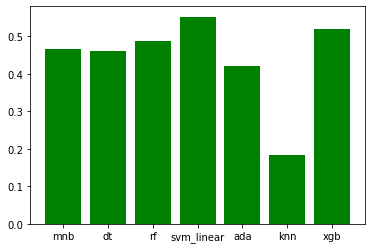

In [46]:
plt.bar(f1_score_dict.keys(), f1_score_dict.values(), color='g')


In [47]:
#SVM gives better performance

In [48]:
SVM.fit(X_train,y_train)
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       0.67      0.25      0.36        24
     Neutral       0.44      0.31      0.36        39
    Positive       0.96      0.98      0.97       937

    accuracy                           0.94      1000
   macro avg       0.69      0.51      0.57      1000
weighted avg       0.93      0.94      0.93      1000



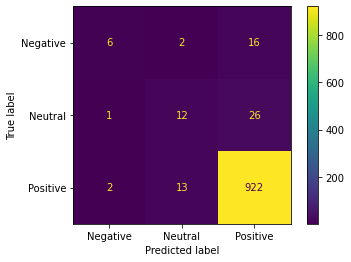

In [49]:
y_pred = SVM.predict(X_test)
plot_confusion_matrix(SVM,X_test,y_test)
plt.show()

#### Will check if using Word2Vec word embedding technique can we get better result than tfidf

In [50]:
df1 = train_df['reviews.text']
df2 = test_df['reviews.text']  
  
frames = [df1, df2]
  
total_reviews = pd.concat(frames)
total_reviews

review_lines = list()

for line in total_reviews:
    tokens = word_tokenize(line)
    lower_tokens  = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in lower_tokens]
    normal_words = [w for w in stripped if w.isalpha()]
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in lower_tokens if w not in stop_words ]
    literals = "~!@#$%^&*()_-+][]}{}.,<>?"
    words = [w for w in normal_words if w not in literals ]
                 
    review_lines.append(words)
    
len(review_lines)

5000

In [51]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = For all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurence
        """
        for word in temp_vocab:
            # 0 does not have a meaning, add the word to the list
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()
     

In [52]:

review_lines = list()

lines = total_reviews.tolist()
for line in lines:
    tokens = word_tokenize(line)
    lower_tokens  = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in lower_tokens]
    normal_words = [w for w in stripped if w.isalpha()]
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in lower_tokens if w not in stop_words ]
    literals = "~!@#$%^&*()_-+][]}{}.,<>?"
    words = [w for w in normal_words if w not in literals ]
                 
    review_lines.append(words)
    
len(review_lines)

5000

In [53]:
#### Save word vectors into a file

import gensim
from gensim.models import Word2Vec
num_features = 10

w2vec_model = gensim.models.Word2Vec(sentences=review_lines,vector_size=100,window=5,workers=4,min_count=1)
words = w2vec_model.wv

filename='word2vec_amazon_review.txt'
w2vec_model.wv.save_word2vec_format(filename,binary=False)

In [54]:
sequencer = Sequencer(all_words = [token for seq in review_lines for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = w2vec_model.wv
             )


In [55]:

X_train_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in X_train_clean])
print(X_train_vecs.shape)
print(y_train.shape)

(3147, 1500)
(3147,)


In [56]:
x_test_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in X_test])
print(x_test_vecs.shape)
print(y_test.shape)

(1000, 1500)
(1000,)


In [57]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)
pca_model.fit(X_train_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

X_train_comps = pca_model.transform(X_train_vecs)
X_test_comps = pca_model.transform(x_test_vecs)
X_train_comps.shape

Sum of variance ratios:  0.9944394315122154


(3147, 50)

In [58]:
DT_w2vec = make_pipeline_imb(SMOTE(), DecisionTreeClassifier())
RF_w2vec = make_pipeline_imb(SMOTE(), RandomForestClassifier())
SVM_w2vec = make_pipeline_imb(SMOTE(), LinearSVC())
ADA_w2vec = make_pipeline_imb(SMOTE(), AdaBoostClassifier())
KNN_w2vec = make_pipeline_imb(SMOTE(), KNeighborsClassifier())
XGB_w2vec = make_pipeline_imb(SMOTE(), XGBClassifier(eval_metric='mlogloss'))

models = {'dt':DT_w2vec,'rf':RF_w2vec,'svm_linear':SVM_w2vec,'ada':ADA_w2vec,'knn':KNN_w2vec,'xgb':XGB_w2vec}

f1_score_dict_w2vec = {}

for i in models:
    print('---------',i)
    models[i].fit(X_train_comps,y_train)
    y_pred = models[i].predict(X_test_comps)
    
    f1score = f1_score(y_test,y_pred,average='macro')
    f1_score_dict_w2vec[i] = f1score
    print(classification_report(y_test, y_pred))


--------- dt
              precision    recall  f1-score   support

    Negative       0.03      0.12      0.05        24
     Neutral       0.04      0.13      0.06        39
    Positive       0.94      0.77      0.84       937

    accuracy                           0.73      1000
   macro avg       0.34      0.34      0.32      1000
weighted avg       0.88      0.73      0.80      1000

--------- rf
              precision    recall  f1-score   support

    Negative       0.17      0.04      0.07        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      0.98      0.96       937

    accuracy                           0.92      1000
   macro avg       0.37      0.34      0.34      1000
weighted avg       0.88      0.92      0.90      1000

--------- svm_linear
              precision    recall  f1-score   support

    Negative       0.03      0.38      0.06        24
     Neutral       0.04      0.33      0.08        39
    Positive       0.94     

<BarContainer object of 6 artists>

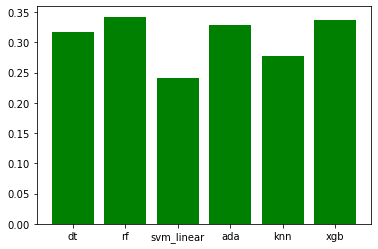

In [59]:
plt.bar(f1_score_dict_w2vec.keys(), f1_score_dict_w2vec.values(), color='g')


In [60]:
#### Using Word2Vec embeding technquies not improving the perfomance of our data. 
# So we use SVM as a final model with tf-idf embedding technique.

In [61]:
# Will do some test on final model with new sample data

postive_review = ["I bought new Alexa for my son and he is very comfortably able to use it"]
postive_review2 = ['the device is very handy, love to buy this device for my nephew also']
neutral_review = ["Amazon firestick is an average device."]
neutral_review2 = ['just an ordinary product']
negative_review = ["Most of the time Alexa not answering properly"]
negative_review2 = ['Order one Alexa, absolutely shocking things with this product. I asked for a refund but never received one. Absolutely horrible customer service from Amazon']
negative_review3 = ['Not happy with the product, so i will not recommend anybody']
negative_review4 = ['Absolutely useless product']
negative_review5 = ['worst product']
negative_review6 = ['totally waste of money']
negative_review7 = ['Not liked so returned']
negative_review8 = ['Not worth to buy Alexa']

In [62]:
models = {'svm':SVM}
for i in models:
    print('---------',i)
    predict_text = models[i].predict(postive_review)
    print('Positive Review',predict_text)
    predict_text = models[i].predict(postive_review2)
    print('Positive Review',predict_text)
    predict_text = models[i].predict(neutral_review)
    print('Neutral Review',predict_text)
    predict_text = models[i].predict(neutral_review2)
    print('Neutral Review',predict_text)
    
    predict_text = models[i].predict(negative_review)
    print('Negative Review',predict_text)
    predict_text = models[i].predict(negative_review2)
    print('Negative Review2',predict_text)
    predict_text = models[i].predict(negative_review3)
    print('Negative Review3',predict_text)
    predict_text = models[i].predict(negative_review4)
    print('Negative Review4',predict_text)
    predict_text = models[i].predict(negative_review5)
    print('Negative Review5',predict_text)
    predict_text = models[i].predict(negative_review6)
    print('Negative Review6',predict_text)
    predict_text = models[i].predict(negative_review7)
    print('Negative Review7',predict_text)
    predict_text = models[i].predict(negative_review8)
    print('Negative Review8',predict_text)

        

--------- svm
Positive Review ['Positive']
Positive Review ['Positive']
Neutral Review ['Positive']
Neutral Review ['Positive']
Negative Review ['Negative']
Negative Review2 ['Negative']
Negative Review3 ['Neutral']
Negative Review4 ['Negative']
Negative Review5 ['Positive']
Negative Review6 ['Negative']
Negative Review7 ['Negative']
Negative Review8 ['Negative']


### Conclusion
Following observations we found in EDA
- 58 duplicate entries found so we removed them.
- 5 yrs data is collected (2014-2018), most of the data collected is in 2017.  
- Majority of reviews on Dec and Jan month. 
- Most of the reviews on Friday, so might be people purchase more on Friday.
- Majority of he reviews is for Electronics category and Alexa device. 

Target label observation
- sentiment is our target label, we found there is a lot of imbalance in target label.
- Data is biased towards Positive sentiment.

For balancing data we use smote technique.
We have also tried tfidf and word2vec embedding technique. In our scenario tfidf gives better performance than word2vec.

Model building
- Sentiment is our target label, Sentiment data is discrete data and contains 3 values. multiclass classiication model we have used for ML model building.
 - During model validation we tried different ML models, Multinomial Naive bayes, Decision Tree,Random Forest,Support Vector Machine, KNN, Adaboost, XGBoost.
 
Model Evaluation
 - Our sentiment data is highly imbalanced because of that we used f1 score for evaluation.
 - Because of extremly high percentage of positive review and very less percentage of Negative and Neutral review we used 
   f1-macro as a evaluation parameter.    

Using hyper parameter tuning as well as deep learning technique we might need to improve the performance of model.